# Previsão de Chuva - Classificação (Abordagem 9)
Abordagem 8, com uma modificação na ordem dos quadrimestres (agora temos Dez-Mar, Abr-Jul, e Ago-Nov).\
Além disso, foram adicionados alguns hiperparâmetros aos modelos, para testar mais possibilidades.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random
plt.style.use('ggplot')
import seaborn as sns

SEED = 0
np.random.seed(SEED)
random.seed(SEED)

In [2]:
import sys
import os

# Adicionar src/ ao path do Python
sys.path.append(os.path.abspath('../src'))

# Agora o import funciona
from data_prep import prep_data

# 1 - Processamento de Dados

## 1.1 - Criação dos Dataframes
Função que faz todo o tratamento dos arquivos de entrada e gera dois Dataframes, um com os dados de entrada, e outro com os dados de saída.\
Código completo no arquivo `data_prep.py`

In [3]:
df_in, df_out = prep_data()

## 1.2 - Separação em Quadrimestres
Reorganizamos os dataframes em Quadrimestres em vez de Meses, agregando os dados.\
Nessa abordagem, usamos a média (`mean`) dos atributos de entrada, e a soma (`sum`) da precipitação total.

In [4]:
# Criar cópias dos dataframes originais para evitar modificações diretas
df_in_copy = df_in.copy()
df_out_copy = df_out.copy()

# Ajustar o ano para Dezembro
df_in_copy.loc[df_in_copy['MON'] == 12, 'YEAR'] += 1
df_out_copy.loc[df_out_copy['MON'] == 12, 'YEAR'] += 1

# Função para identificar o quadrimestre
def assign_quad(month):
    if month in [12, 1, 2, 3]:
        return 1
    elif month in [4, 5, 6, 7]:
        return 2
    elif month in [8, 9, 10, 11]:
        return 3

# Adicionar a coluna de quadrimestre
df_in_copy['QUAD'] = df_in_copy['MON'].apply(assign_quad)
df_out_copy['QUAD'] = df_out_copy['MON'].apply(assign_quad)

# Remover a coluna "MON" após criar "QUAD"
df_in_copy = df_in_copy.drop(columns=['MON'])
df_out_copy = df_out_copy.drop(columns=['MON'])

# Filtrar os dados de entrada e saída para incluir apenas anos de 1982 a 2023
df_in_copy = df_in_copy[(df_in_copy['YEAR'] >= 1982) & (df_in_copy['YEAR'] <= 2023)]
df_out_copy = df_out_copy[(df_out_copy['YEAR'] >= 1982) & (df_out_copy['YEAR'] <= 2023)]

# Função para calcular próximo quadrimestre
def proximo_quadrimestre(row):
    year = row['YEAR']
    quad = row['QUAD']
    if quad == 3:
        return pd.Series({'NEXT_YEAR': year + 1, 'NEXT_QUAD': 1})
    else:
        return pd.Series({'NEXT_YEAR': year, 'NEXT_QUAD': quad + 1})

# Adicionar colunas de próximo quadrimestre
df_in_copy[['NEXT_YEAR', 'NEXT_QUAD']] = df_in_copy.apply(proximo_quadrimestre, axis=1)

# Agregar dados de entrada (média) e saída (soma)
aggregated_in = df_in_copy.groupby(['YEAR', 'QUAD']).mean().reset_index()
aggregated_out = df_out_copy.groupby(['YEAR', 'QUAD'])['PRECIP'].sum().reset_index()

# Renomear colunas do target
aggregated_out_renamed = aggregated_out.rename(
    columns={'YEAR': 'NEXT_YEAR', 'QUAD': 'NEXT_QUAD', 'PRECIP': 'PRECIP_NEXT_QUAD'}
)

# Mesclar dados
aggregated_data = pd.merge(
    aggregated_in,
    aggregated_out_renamed,
    on=['NEXT_YEAR', 'NEXT_QUAD'],
    how='inner'
)

# Remove o primeiro quadrimestre, que contém dados incompletos.
aggregated_data.drop(0, inplace=True)
aggregated_data.reset_index(drop=True, inplace=True)

In [5]:
aggregated_data

,YEAR,QUAD,1_TW_CP,2_DarwinPr,3_TW_EP,4_TahitiPr,5_TW_WP,6_NATL,6_SATL,6_TROP,7_NINO1+2,7_NINO3,7_NINO4,7_NINO3.4,NEXT_YEAR,NEXT_QUAD,PRECIP_NEXT_QUAD
0,1982,2,6.200,12.600,8.550,12.475,0.200,26.1600,24.7025,27.9775,23.3800,27.1150,29.0050,28.0300,1982.0,3.0,379.706667
1,1982,3,2.125,13.075,7.375,11.825,-2.975,27.2375,22.6900,27.3450,22.6725,26.7450,28.8925,28.1925,1983.0,1.0,536.166667
2,1983,1,1.050,9.875,4.675,8.250,0.975,25.6375,25.7325,28.0725,27.1350,28.3275,28.6350,28.6350,1983.0,2.0,648.500000
3,1983,2,4.150,12.375,4.275,13.150,2.825,26.6500,24.7525,28.1825,27.2150,28.0125,28.6750,28.0450,1983.0,3.0,334.471429
4,1983,3,9.525,11.600,10.125,14.550,3.000,27.3650,23.0525,27.1100,22.4700,24.9250,27.9000,26.0300,1984.0,1.0,304.357143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,2022,1,11.975,6.850,11.625,12.925,3.575,26.2775,26.3850,27.7325,23.9350,25.0850,27.7825,25.9225,2022.0,2.0,1376.061905
120,2022,2,10.850,10.925,9.300,14.700,6.325,26.7725,25.6900,28.0100,22.4875,26.1275,27.9725,26.8475,2022.0,3.0,397.715476
121,2022,3,11.050,10.350,9.725,14.825,5.500,28.1275,23.6500,27.2375,19.7700,24.3450,27.7000,25.8900,2023.0,1.0,414.773810
122,2023,1,12.100,6.325,11.375,12.500,4.000,26.0925,26.3950,27.8125,25.4325,25.8550,27.7500,26.3025,2023.0,2.0,1003.631548


# 2 - Códigos de Preparação

## 2.2 - Lista de Modelos

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from data_transformations_util import IdentityTransformer

# Função para criar a pipeline genérica
def create_generic_pipeline(classifier):
    return Pipeline([
        ('scaler', StandardScaler()),  # Etapa obrigatória
        ('pca', IdentityTransformer()),  # PCA opcional (controlado via grid)
        ('classifier', classifier)      # Classificador específico
    ])

# Lista de modelos atualizada
lista_modelos = [
        {
            "nome_do_modelo": "Random Forest",
            "estimador": create_generic_pipeline(RandomForestClassifier(random_state=SEED)),
            "parametros": {
                'pca': [IdentityTransformer(), PCA(n_components=2), PCA(n_components=3), PCA(n_components=0.8)],
                'classifier__n_estimators': [10, 30, 50],
                'classifier__max_depth': [3, 4, 5],
                'classifier__min_samples_split': [2, 4, 8],
                'classifier__class_weight': ['balanced', None]
            }
        },
    
        # ==============================
        # 2. Logistic Regression
        # ==============================
        {
            "nome_do_modelo": "Logistic Regression",
            "estimador": create_generic_pipeline(LogisticRegression(
                max_iter=1000,
                random_state=SEED
            )),
            "parametros": {
                'pca': [IdentityTransformer(), PCA(n_components=2), PCA(n_components=3), PCA(n_components=0.8)],
                'classifier__C': [0.01, 0.1, 1],
                'classifier__penalty': ['l1', 'l2'],
                'classifier__solver': ['saga']
            }
        },
    
        # ==============================
        # 3. KNN
        # ==============================
        {
            "nome_do_modelo": "KNN",
            "estimador": create_generic_pipeline(KNeighborsClassifier()),
            "parametros": {
                'pca': [IdentityTransformer(), PCA(n_components=2), PCA(n_components=3), PCA(n_components=0.8)],
                'classifier__n_neighbors': [1, 3, 5, 10, 20],
                'classifier__weights': ['uniform', 'distance']
            }
        },
    
        # ==============================
        # 4. SVM
        # ==============================
        {
            "nome_do_modelo": "SVM",
            "estimador": create_generic_pipeline(SVC(
                probability=True,
                random_state=SEED,
                class_weight='balanced'
            )),
            "parametros": {
                'pca': [IdentityTransformer(), PCA(n_components=2), PCA(n_components=3), PCA(n_components=0.8)],
                'classifier__C': [0.1, 0.5, 1, 10, 20],
                'classifier__kernel': ['linear'],
                'classifier__class_weight': ['balanced', None],
                'classifier__gamma': ['scale', 'auto']
            }
        }
    ]

# 3 - Treinamento

In [7]:
from classification_train_util_7 import nested_cross_validation_grid_search

# Atualizar o DataFrame X para incluir 'PRECIP_NEXT_QUAD'
X = aggregated_data.drop(columns=['YEAR', 'QUAD', 'NEXT_YEAR'])

# Chamar a função de validação cruzada usando a lista de modelos existente
resultados_gerais = nested_cross_validation_grid_search(
    lista_modelos=lista_modelos,
    X=X,
    k_folds_outer=3,
    k_folds_inner=3,
    rand_state=SEED
)

Treinando modelo Random Forest ..........................................................................................Treinando modelo Logistic Regression .........................................

C:\Users\gfern\OneDrive\Área de Trabalho\Coding\tcc\tccenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


.

C:\Users\gfern\OneDrive\Área de Trabalho\Coding\tcc\tccenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


...........

C:\Users\gfern\OneDrive\Área de Trabalho\Coding\tcc\tccenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gfern\OneDrive\Área de Trabalho\Coding\tcc\tccenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


...............................

C:\Users\gfern\OneDrive\Área de Trabalho\Coding\tcc\tccenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


......Treinando modelo KNN ..........................................................................................Treinando modelo SVM ..........................................................................................Terminado em 09/03/2025 10:33:50


# 4 - Resultados

In [8]:
# Converter os resultados para DataFrame
df_resultados = pd.DataFrame(resultados_gerais).T.reset_index()
df_resultados = df_resultados.rename(columns={'index': 'Modelo'})

# Selecionar colunas relevantes
colunas = ['Modelo', 'F1_score_mean', 'Acurácia_mean', 'Precisão_mean', 'Recall_mean']
df_comparacao = df_resultados[colunas]

# Ordenar pelo F1-score (métrica principal)
df_comparacao = df_comparacao.sort_values('F1_score_mean', ascending=False)

print(df_comparacao)

                Modelo F1_score_mean Acurácia_mean Precisão_mean Recall_mean
3                  SVM      0.606696      0.612376       0.60572    0.621604
0        Random Forest      0.589024      0.581443      0.571496    0.625794
1  Logistic Regression      0.562728      0.600039      0.573843     0.56537
2                  KNN       0.54287       0.55853      0.561044    0.543159


<Figure size 1000x600 with 0 Axes>

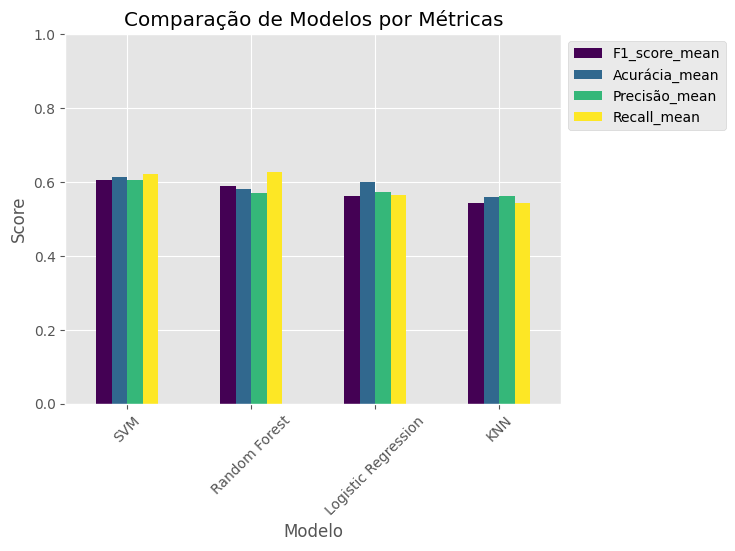

In [9]:
# Configurar o gráfico
plt.figure(figsize=(10, 6))
df_comparacao.set_index('Modelo').plot(kind='bar', rot=45, colormap='viridis')
plt.title('Comparação de Modelos por Métricas')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [10]:
for index, row in df_resultados.iterrows():
    print(f"Modelo: {row['Modelo']}")
    print("Melhores Parâmetros:")

    # Garantir que há parâmetros salvos
    if row['melhores_parametros'] and row['F1_score_list']:
        # Encontrar o índice do melhor F1-score médio
        melhor_indice = np.argmax(row['F1_score_list'])
        
        # Obter os melhores parâmetros correspondentes
        melhores_parametros = row['melhores_parametros'][melhor_indice]

        # Exibir os melhores parâmetros
        for param, value in melhores_parametros.items():
            print(f"  - {param}: {value}")
    else:
        print("  - Nenhum parâmetro encontrado.")

    print("-" * 50)

Modelo: Random Forest
Melhores Parâmetros:
  - classifier__class_weight: None
  - classifier__max_depth: 4
  - classifier__min_samples_split: 4
  - classifier__n_estimators: 10
  - pca: IdentityTransformer()
--------------------------------------------------
Modelo: Logistic Regression
Melhores Parâmetros:
  - classifier__C: 1
  - classifier__penalty: l1
  - classifier__solver: saga
  - pca: IdentityTransformer()
--------------------------------------------------
Modelo: KNN
Melhores Parâmetros:
  - classifier__n_neighbors: 20
  - classifier__weights: uniform
  - pca: PCA(n_components=2)
--------------------------------------------------
Modelo: SVM
Melhores Parâmetros:
  - classifier__C: 20
  - classifier__class_weight: balanced
  - classifier__gamma: scale
  - classifier__kernel: linear
  - pca: IdentityTransformer()
--------------------------------------------------


In [11]:
# Criar o DataFrame consolidado com métricas e desvios
df_comparacao = df_resultados[[
    'Modelo', 
    'F1_score_mean', 'F1_score_std',
    'Acurácia_mean', 'Acurácia_std',
    'Precisão_mean', 'Precisão_std',
    'Recall_mean', 'Recall_std'
]]

# Ordenar pelo F1-score (métrica principal)
df_comparacao = df_comparacao.sort_values('F1_score_mean', ascending=False)

# Formatar a exibição
print("\n=== Resultados Consolidados (Média ± Desvio Padrão) ===\n")
for i in range(len(df_comparacao)):
    modelo = df_comparacao.iloc[i]['Modelo']
    f1_mean = df_comparacao.iloc[i]['F1_score_mean']
    f1_std = df_comparacao.iloc[i]['F1_score_std']
    acc_mean = df_comparacao.iloc[i]['Acurácia_mean']
    acc_std = df_comparacao.iloc[i]['Acurácia_std']
    pre_mean = df_comparacao.iloc[i]['Precisão_mean']
    pre_std = df_comparacao.iloc[i]['Precisão_std']
    rec_mean = df_comparacao.iloc[i]['Recall_mean']
    rec_std = df_comparacao.iloc[i]['Recall_std']

    print(f"Modelo: {modelo}")
    print(f"  - F1-Score: {f1_mean:.3f} ± {f1_std:.3f}")
    print(f"  - Acurácia: {acc_mean:.3f} ± {acc_std:.3f}")
    print(f"  - Precisão: {pre_mean:.3f} ± {pre_std:.3f}")
    print(f"  - Recall: {rec_mean:.3f} ± {rec_std:.3f}")
    print("\n" + "-" * 50 + "\n")


=== Resultados Consolidados (Média ± Desvio Padrão) ===

Modelo: SVM
  - F1-Score: 0.607 ± 0.092
  - Acurácia: 0.612 ± 0.073
  - Precisão: 0.606 ± 0.106
  - Recall: 0.622 ± 0.118

--------------------------------------------------

Modelo: Random Forest
  - F1-Score: 0.589 ± 0.087
  - Acurácia: 0.581 ± 0.070
  - Precisão: 0.571 ± 0.096
  - Recall: 0.626 ± 0.126

--------------------------------------------------

Modelo: Logistic Regression
  - F1-Score: 0.563 ± 0.159
  - Acurácia: 0.600 ± 0.077
  - Precisão: 0.574 ± 0.178
  - Recall: 0.565 ± 0.169

--------------------------------------------------

Modelo: KNN
  - F1-Score: 0.543 ± 0.105
  - Acurácia: 0.559 ± 0.088
  - Precisão: 0.561 ± 0.129
  - Recall: 0.543 ± 0.124

--------------------------------------------------

